In [936]:
import torch
import random
import numpy as np
from deepSVDD import DeepSVDD
from datasets.main import load_dataset
from base.base_dataset import BaseADDataset
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.utils import resample

In [937]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        """
        初始化 Dataset
        :param data: 已處理的特徵數據 (NumPy array or Pandas DataFrame)
        :param labels: 對應的標籤數據
        """
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        """返回數據集大小"""
        return len(self.data)

    def __getitem__(self, idx):
        """根據索引返回一筆數據及其標籤"""
        return self.data[idx], self.labels[idx], idx

class MyADDataset(BaseADDataset):
    def __init__(self):
        super().__init__(r'multiclass15\csv_result-data1 Sampled Scenarios.csv')

    def process_data(self, file_path):
        # 讀取資料
        df=pd.read_csv(r'multiclass15\csv_result-data1 Sampled Scenarios.csv')
        
        # df = pd.read_csv(file_path)
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
        df = df.drop('id', axis=1)
        
        # 標籤處理
        y = df['marker']
        y = [0 if value in [41] else 1 for value in y]
        X = df.drop('marker', axis=1)

        # 刪除不必要的欄位
        columns_to_drop = ['control_panel_log1', 'control_panel_log2', 'control_panel_log3', 
                        'control_panel_log4', 'relay1_log', 'relay2_log', 'relay3_log', 
                        'relay4_log', 'snort_log1', 'snort_log2', 'snort_log3', 'snort_log4']
        X = X.drop(columns=columns_to_drop, axis=1)
        
        # 分割數據集
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        X_train_df = pd.DataFrame(X_train)
        y_train_df = pd.DataFrame(y_train, columns=['label'])

        X_train_df.reset_index(drop=True, inplace=True)
        y_train_df.reset_index(drop=True, inplace=True)

        merged_df = pd.concat([X_train_df, y_train_df], axis=1)
        
        label_0_data = merged_df[merged_df['label'] == 0]
        train_data = label_0_data.drop('label', axis=1)

        # Min-Max 標準化
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(train_data)
        X_test = scaler.transform(X_test)

        return X_train, X_test, y_train, y_test

    def create_dataloaders(self, file_path, batch_size=32, num_workers=0):
        # 處理數據
        X_train, X_test, y_train, y_test = self.process_data(file_path)

        # 建立 Dataset
        train_dataset = CustomDataset(X_train, y_train)
        test_dataset = CustomDataset(X_test, y_test)

        # 建立 DataLoader
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        return train_loader, test_loader
    
    def loaders(self, batch_size, shuffle_train=True, shuffle_test=False, num_workers = 0):
        train_loader, test_loader = self.create_dataloaders(self.root, batch_size=batch_size)
        return train_loader, test_loader


def test_deep_svdd():
    # 隨便填一些測試參數
    net_name = 'feature_net'
    normal_class = 0
    nu = 0.1
    objective = 'one-class'
    device = 'cuda'

    print("開始測試 DeepSVDD...")

    # 初始化 DeepSVDD 並設定網路
    deep_svdd = DeepSVDD(objective, nu)
    deep_svdd.set_network(net_name)

    data = MyADDataset()

    # 測試 train
    print("開始訓練...")
    deep_svdd.train(
        data,
        optimizer_name='adam',
        lr=0.001,
        n_epochs=150, 
        lr_milestones=[],
        batch_size=64,
        weight_decay=1e-6,
        device=device,
        n_jobs_dataloader=0
    )
    print("訓練完成。")

    # 測試 test
    print("開始測試...")
    deep_svdd.test(data, device=device, n_jobs_dataloader=0)

    print("測試完成。")

    return deep_svdd.results, deep_svdd.getNet(), data

In [938]:
import logging
logger = logging.getLogger()

results, net, dataset = test_deep_svdd()

開始測試 DeepSVDD...
開始訓練...


c:\Users\user\AppData\Local\anaconda3\envs\DeepSVDD\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


訓練完成。
開始測試...
測試完成。


In [939]:
def get_hyperFeature(TrainTest):
    net.eval()
    train_loader, test_loader = dataset.loaders(batch_size=64, num_workers=0)
    hyperFeature = []

    if TrainTest == 'train':
        loader = train_loader
    else:
        loader = test_loader

    with torch.no_grad():
        for data in loader:
            inputs, labels, idx = data
            inputs = inputs.to('cuda')

            # 找到你了 小調皮
            outputs = net(inputs)

            hyperFeature.append(outputs.cpu().numpy())

    hyperFeatureNP = np.vstack(hyperFeature)
    return hyperFeatureNP

In [940]:
train_loader, test_loader = dataset.loaders(batch_size=64, num_workers=0)
loader = test_loader

all_inputs = []
all_labels = []

for data in loader:
    inputs, labels, idx = data
    # 把 inputs 和 labels 轉為 NumPy 陣列
    inputs_np = inputs.numpy()  # 假設 inputs 是 torch.Tensor
    labels_np = labels.numpy()  # 假設 labels 是 torch.Tensor

    # 將每批資料加入到列表中
    all_inputs.append(inputs_np)
    all_labels.append(labels_np)

# 將所有批次堆疊到一起
all_inputs = np.vstack(all_inputs)  # 堆疊資料
all_labels = np.concatenate(all_labels)  # 將標籤展開成一維陣列

# 儲存到一個 NumPy 陣列（若要直接結合資料和標籤）
dataset_np = np.hstack((all_inputs, all_labels[:, None]))  # 假設每個樣本對應一個標籤

In [941]:
indices_0 = np.where(all_labels == 0)[0]
indices_1 = np.where(all_labels == 1)[0]

# 確保取樣的數量相等
num_samples = min(len(indices_0), len(indices_1))

# 隨機選擇索引
random_indices_0 = np.random.choice(indices_0, num_samples, replace=False)
random_indices_1 = np.random.choice(indices_1, num_samples, replace=False)

# 合併索引並打亂順序
selected_indices = np.concatenate([random_indices_0, random_indices_1])
np.random.shuffle(selected_indices)

# 提取對應的資料和標籤
balanced_inputs = all_inputs[selected_indices]
balanced_labels = all_labels[selected_indices]

print(f"取樣後資料形狀: {balanced_inputs.shape}, 標籤形狀: {balanced_labels.shape}")

取樣後資料形狀: (70, 116), 標籤形狀: (70,)


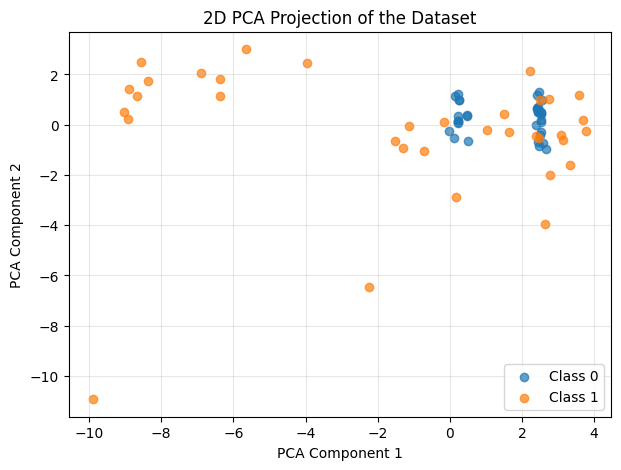

In [942]:
import matplotlib.pyplot as plt

# 將資料降維到 2D
pca = PCA(n_components=15)
reduced_data = pca.fit_transform(balanced_inputs)

# 獲取每個標籤對應的資料點
label_0_data = reduced_data[balanced_labels == 0]
label_1_data = reduced_data[balanced_labels == 1]

# 繪製散點圖
plt.figure(figsize=(7, 5))
plt.scatter(label_0_data[:, 0], label_0_data[:, 2], label="Class 0", alpha=0.7)
plt.scatter(label_1_data[:, 0], label_1_data[:, 2], label="Class 1", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA Projection of the Dataset")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [943]:
balanced_inputs.shape

(70, 116)

In [944]:
# 確保模型處於評估模式
net.eval()

# 初始化存儲輸出的列表
hyperFeature = []

# 禁用梯度計算，進行推論
with torch.no_grad():
    # 將 NumPy 資料轉為 Torch Tensor
    inputs_tensor = torch.tensor(balanced_inputs, dtype=torch.float32).to('cuda')
    
    # 如果資料量過大，可以分批處理
    batch_size = 64
    for i in range(0, len(inputs_tensor), batch_size):
        batch_inputs = inputs_tensor[i:i+batch_size]
        
        # 通過模型獲取輸出
        outputs = net(batch_inputs)
        
        # 將輸出移到 CPU 並轉為 NumPy 格式
        hyperFeature.append(outputs.cpu().numpy())

# 將所有批次的輸出合併
hyperFeature = np.vstack(hyperFeature)

print(f"推論完成，輸出形狀為: {hyperFeature.shape}")

推論完成，輸出形狀為: (70, 2)


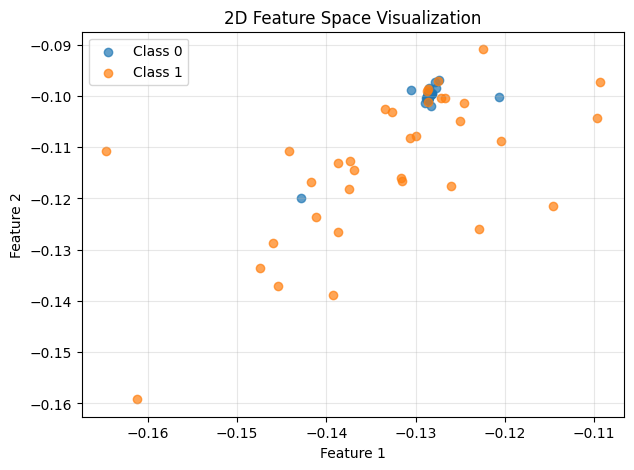

In [945]:
# 獲取標籤對應的資料
label_0_data = hyperFeature[balanced_labels == 0]
label_1_data = hyperFeature[balanced_labels == 1]

# 繪製散點圖
plt.figure(figsize=(7, 5))
plt.scatter(label_0_data[:, 0], label_0_data[:, 1], label="Class 0", alpha=0.7)
plt.scatter(label_1_data[:, 0], label_1_data[:, 1], label="Class 1", alpha=0.7)

# 圖片標籤
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("2D Feature Space Visualization")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [946]:
trainHF = get_hyperFeature('train')
testHF = get_hyperFeature('test')

print(trainHF)
print(testHF)

[[-0.12873986 -0.10109311]
 [-0.1285377  -0.09984085]
 [-0.12809488 -0.09836271]
 [-0.12881699 -0.10032073]
 [-0.12874082 -0.10106514]
 [-0.12889344 -0.10135517]
 [-0.12881905 -0.10033044]
 [-0.1285595  -0.09990887]
 [-0.12868826 -0.10087852]
 [-0.12842229 -0.09970436]
 [-0.12859383 -0.09949757]
 [-0.12868237 -0.10042249]
 [-0.12846418 -0.10062407]
 [-0.12869507 -0.09995711]
 [-0.12876095 -0.10054377]
 [-0.12850282 -0.09951788]
 [-0.12824787 -0.09967493]
 [-0.1284821  -0.09957623]
 [-0.12871407 -0.10014637]
 [-0.1283427  -0.09946845]
 [-0.12848225 -0.09963454]
 [-0.12805083 -0.09980178]
 [-0.12859483 -0.09984916]
 [-0.12868239 -0.10030194]
 [-0.12870242 -0.10005765]
 [-0.12847145 -0.09947176]
 [-0.12859827 -0.09973463]
 [-0.12853357 -0.09980166]
 [-0.12876073 -0.09976381]
 [-0.12848282 -0.09963425]
 [-0.12887122 -0.10125351]
 [-0.12869638 -0.1008033 ]
 [-0.12873816 -0.10044734]
 [-0.12863174 -0.10024944]
 [-0.12886694 -0.10072859]
 [-0.12872976 -0.10041811]
 [-0.12867261 -0.10026684]
 

In [947]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators= 130, bootstrap=True, max_features=7)

# Fit the model on the hyperFeatureNP data
iso_forest.fit(trainHF)

# Predict anomalies
anomaly_scores = iso_forest.decision_function(testHF)
anomalies = iso_forest.predict(testHF)

# Convert predictions to binary labels (1 for normal, -1 for anomaly)
anomalies = [1 if x == -1 else 0 for x in anomalies]

# Print the number of detected anomalies
print(f"Number of detected anomalies: {sum(anomalies)}")

from sklearn.metrics import roc_auc_score, precision_score
# Calculate AUC-ROC

y_true = []
_, test_loader = dataset.loaders(batch_size=64, num_workers=0)
for data in test_loader:
    _, labels, _ = data
    y_true.append(labels.cpu().numpy())

y_true = np.hstack(y_true)

auc_roc = roc_auc_score(y_true, -anomaly_scores)
print(f"AUC-ROC: {auc_roc}")

ValueError: max_features must be <= n_features

In [118]:
trainScore = iso_forest.decision_function(trainHF)

threshold = np.percentile(trainScore, 50)